In [16]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

import os
import json

In [17]:
using_colab = False

try: 
    from google.colab import drive
    
    drive.mount('/content/MyDrive')
    using_colab = True
    
except: using_colab = False

In [18]:
using_colab

False

# Read label data

In [19]:
label_path = '../label/'
image_path = '../data/'

In [20]:
list_annot_file = os.listdir(label_path)

In [21]:
list_annot_file

['driver_37_30frame-05181432_0203.MP4.json',
 'driver_37_30frame-05181520_0219.MP4.json',
 'driver_37_30frame-05181608_0235.MP4_project.json',
 'driver_37_30frame-05181656_0251.MP4.json',
 'driver_37_30frame-05181743_0267.MP4.json',
 'driver_37_30frame-05181919_0299.MP4_project.json',
 'driver_37_30frame-05190613_0331.MP4_project.json',
 'driver_37_30frame-05190703_0347.MP4_project.json',
 'driver_37_30frame-05190751_0363.MP4_project.json',
 'driver_37_30frame-05190839_0379.MP4_project.json',
 'driver_37_30frame-05190927_0395.MP4_project.json']

In [22]:
data = json.load(open(label_path + list_annot_file[0]))

In [23]:
def json_annot_to_df(file_path):
    file = open(file_path)
    data = json.load(file)
    
    location = data['_via_settings']['core']['default_filepath'].split('data\\')[1]
    
    file_names = []
    regions = []
    
    for key, value in data['_via_img_metadata'].items():
        if len(value['regions']) > 0:
            file_names.append(location + value['filename'])
            regions.append(value['regions'])
    
    return pd.DataFrame({'file_name': file_names, 'regions': regions})

In [24]:
def bound_rectangle(points, image_shape=(1, 1)):
    min_x = np.min(points[:, 0])
    max_x = np.max(points[:, 0])
    min_y = np.min(points[:, 1])
    max_y = np.max(points[:, 1])

    return [min_x, max_x, min_y, max_y], [min_x/image_shape[1], max_x/image_shape[1], min_y/image_shape[0], max_y/image_shape[0]]

def draw_rectangle(image, rect_shape):
    cv2.polylines(image, [np.array([[rect_shape[0], rect_shape[2]], [rect_shape[1], rect_shape[2]], [rect_shape[1], rect_shape[3]], 
                                    [rect_shape[0], rect_shape[3]]])], True, (255, 0, 0), 2)

In [25]:
def get_label(file_path):
    values = json_annot_to_df(file_path).values
    
    file_names = []
    rectangles = []
    std_rectangles = []
    labels = []

    for value in values:
        file_name, regions = value
        for region in regions:
            try:
                annot = region['shape_attributes']
                label = region['region_attributes']['label']
                pts = np.array([[annot['all_points_x'][i], annot['all_points_y'][i]] for i in range(len(annot['all_points_x']))])
                bound, std_bound = bound_rectangle(pts, image_shape=(560, 1640))
                file_names.append(file_name)
                rectangles.append(bound)
                std_rectangles.append(std_bound)
                labels.append(label.split('\n')[0])
            except: pass
    
    return file_names, rectangles, std_rectangles, labels

In [26]:
file_names = []
bounds = []
std_bounds = []
labels = []
images = []

for file in list_annot_file:
    _file_names, _bounds, _std_bounds, _labels = get_label(label_path + file)
    file_names.extend(_file_names)
    bounds.extend(_bounds)
    std_bounds.extend(_std_bounds)
    labels.extend(_labels)
    
for file_name in file_names:
    img = cv2.imread(image_path + file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    images.append(img)
    
images = np.array(images)

In [27]:
np.unique(np.array(labels))

array(['arrow', 'crossing', 'fishbone'], dtype='<U8')

In [28]:
images

array([[[ 65,  66,  68, ..., 103, 104, 104],
        [ 68,  68,  67, ..., 104, 105, 105],
        [ 67,  67,  67, ..., 106, 106, 106],
        ...,
        [ 73,  73,  73, ...,  22,  22,  21],
        [ 74,  73,  74, ...,  20,  21,  21],
        [ 75,  74,  74, ...,  18,  20,  20]],

       [[ 64,  65,  66, ...,  58,  63,  64],
        [ 80,  73,  67, ...,  62,  67,  69],
        [ 68,  64,  63, ...,  63,  64,  68],
        ...,
        [ 77,  77,  76, ...,  18,  18,  17],
        [ 75,  71,  71, ...,  18,  18,  18],
        [ 71,  67,  62, ...,  18,  19,  19]],

       [[ 71,  72,  73, ...,  59,  60,  62],
        [ 73,  70,  66, ...,  61,  62,  63],
        [ 72,  72,  71, ...,  64,  64,  65],
        ...,
        [ 78,  77,  75, ...,  19,  19,  19],
        [ 76,  75,  73, ...,  18,  18,  18],
        [ 74,  73,  72, ...,  17,  17,  17]],

       ...,

       [[255, 255, 255, ..., 104, 123, 148],
        [255, 255, 255, ..., 112, 124, 151],
        [255, 255, 255, ...,  95,  91, 102

In [29]:
def load_data(path):
    images = np.loadtxt(path + 'image_data.csv', delimiter=',')
    images.reshape(129, 590, 1640)
    std_bounds = np.loadtxt(path + 'bound_data.csv', delimiter=',')
    encoded_label = np.loadtxt(path + 'label_data.csv', delimiter=',')
    labels = np.loadtxt(path + 'labels.txt', delimiter='\n')
    
    return images, std_bounds, encoded_label, labels

- Example of label reading

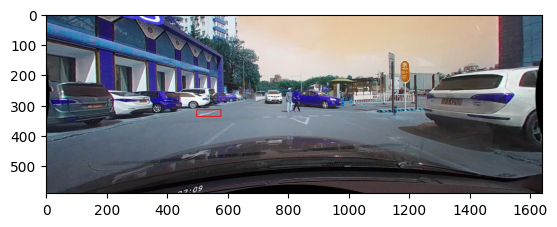

In [30]:
show_data = json_annot_to_df(label_path + list_annot_file[0]).values[0]
image = cv2.imread(image_path + show_data[0])

polygons = []
for region in show_data[1]:
    annot = region['shape_attributes']
    pts = np.array([[annot['all_points_x'][i], annot['all_points_y'][i]] for i in range(len(annot['all_points_x']))])
    polygons.append(pts)
    
for polygon in polygons:
    rect_shape, _ = bound_rectangle(polygon)
    draw_rectangle(image, rect_shape)
plt.imshow(image)

# Model

- data adaptation

In [33]:
encoder = LabelEncoder()

In [34]:
encoded_labels = encoder.fit_transform(labels)
encoded_labels_categorical = tf.keras.utils.to_categorical(encoded_labels) # to categorical

In [35]:
def data_to_files(images, std_bounds, encoded_labels, encoder):
    np.savetxt('image_data.csv', images.reshape(images.shape[0], -1), delimiter=',', fmt='%d')
    np.savetxt('bound_data.csv', std_bounds, delimiter=',')
    np.savetxt('label_data.csv', encoded_labels, delimiter=',', fmt='%d')
    np.savetxt('labels.txt', encoder.classes_, delimiter='\n', fmt='%s')

In [37]:
if not using_colab:
    data_to_files(images, std_bounds, encoded_labels, encoder)

RuntimeError: must train on colab

In [ ]:
X = images[:]
Y = [tf.constant(std_bounds, dtype=tf.float32), encoded_labels_categorical]

In [ ]:
X = np.expand_dims(images, axis=3)
X = tf.convert_to_tensor(X, dtype=tf.float32)

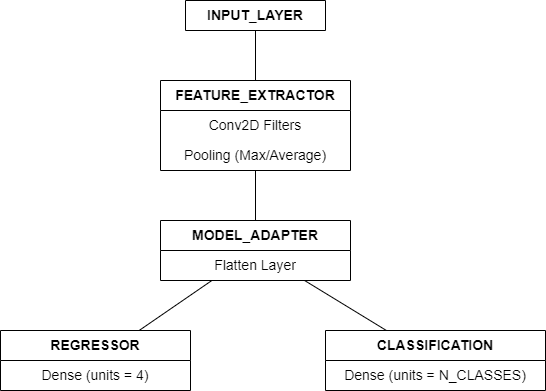

In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open('model_structure.png')
display(img)

In [ ]:
DROPOUT_FACTOR = 0.5
CLASSES = 3

def standalize_input(inputs):
    
    x = tf.keras.layers.Lambda(lambda x: x/255.)(inputs)
    
    return x

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(4, kernel_size=3, activation='relu', input_shape=(590, 1640, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)
    
    x = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)
    
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name='classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units='4', name='regressor_head')(inputs)

def build_model(inputs):
    
    input_standalizer = standalize_input(inputs)
    
    feature_extractor = build_feature_extractor(input_standalizer)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs=inputs, outputs=[regressor_head, classification_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head': 'categorical_crossentropy', 'regressor_head': 'mse' }, 
              metrics = {'classifier_head': 'accuracy', 'regressor_head': 'mse' },
              run_eagerly=True)

    return model

In [ ]:
model = build_model(tf.keras.layers.Input(shape=(590, 1640, 1,)))

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 590, 1640, 1)]       0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 590, 1640, 1)         0         ['input_3[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 588, 1638, 4)         40        ['lambda_1[0][0]']            
                                                                                                  
 average_pooling2d_10 (Aver  (None, 294, 819, 4)          0         ['conv2d_10[0][0]']           
 agePooling2D)                                                                              

In [ ]:
EPOCHS = 5
BATCH_SIZE = 32

history = model.fit(X, Y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=2)

Epoch 1/5
5/5 - 34s - loss: 1.2757 - regressor_head_loss: 0.2076 - classifier_head_loss: 1.0682 - regressor_head_mse: 0.2076 - classifier_head_accuracy: 0.6434 - 34s/epoch - 7s/step
Epoch 2/5
5/5 - 12s - loss: 1.1152 - regressor_head_loss: 0.0880 - classifier_head_loss: 1.0272 - regressor_head_mse: 0.0880 - classifier_head_accuracy: 0.7442 - 12s/epoch - 2s/step
Epoch 3/5
5/5 - 12s - loss: 0.9166 - regressor_head_loss: 0.0319 - classifier_head_loss: 0.8847 - regressor_head_mse: 0.0319 - classifier_head_accuracy: 0.6899 - 12s/epoch - 2s/step
Epoch 4/5
5/5 - 13s - loss: 0.8675 - regressor_head_loss: 0.0441 - classifier_head_loss: 0.8234 - regressor_head_mse: 0.0441 - classifier_head_accuracy: 0.6899 - 13s/epoch - 3s/step
Epoch 5/5
5/5 - 12s - loss: 0.8445 - regressor_head_loss: 0.0254 - classifier_head_loss: 0.8191 - regressor_head_mse: 0.0254 - classifier_head_accuracy: 0.6899 - 12s/epoch - 2s/step
